hello section

In [49]:
library(tidyverse)
library(repr)
library(tidymodels)
players <- read_csv("players.csv")
sessions <- read_csv("sessions.csv")
library(dplyr)

session_counts <- sessions |>
  group_by(hashedEmail) |>
  summarise(num_sessions = n())

session_durations <- sessions |>
  mutate(duration_min = (original_end_time - original_start_time) / 60000) |>
  group_by(hashedEmail) |>
  summarise(avg_duration = mean(duration_min, na.rm = TRUE))
library(dplyr)

players <- players |>
  left_join(session_counts, by = "hashedEmail") |>
  left_join(session_durations, by = "hashedEmail")|>
    select(subscribe,num_sessions,gender)|>
filter(num_sessions	!= "NA")

players



Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 1535 Columns: 5
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (3): hashedEmail, start_time, end_time
dbl (2): original_start_time, original_end_time

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


subscribe,num_sessions,gender
<lgl>,<int>,<chr>
TRUE,27,Male
TRUE,3,Male
FALSE,1,Male
TRUE,1,Female
TRUE,1,Male
FALSE,1,Male
TRUE,1,Male
TRUE,3,Female
TRUE,1,Female


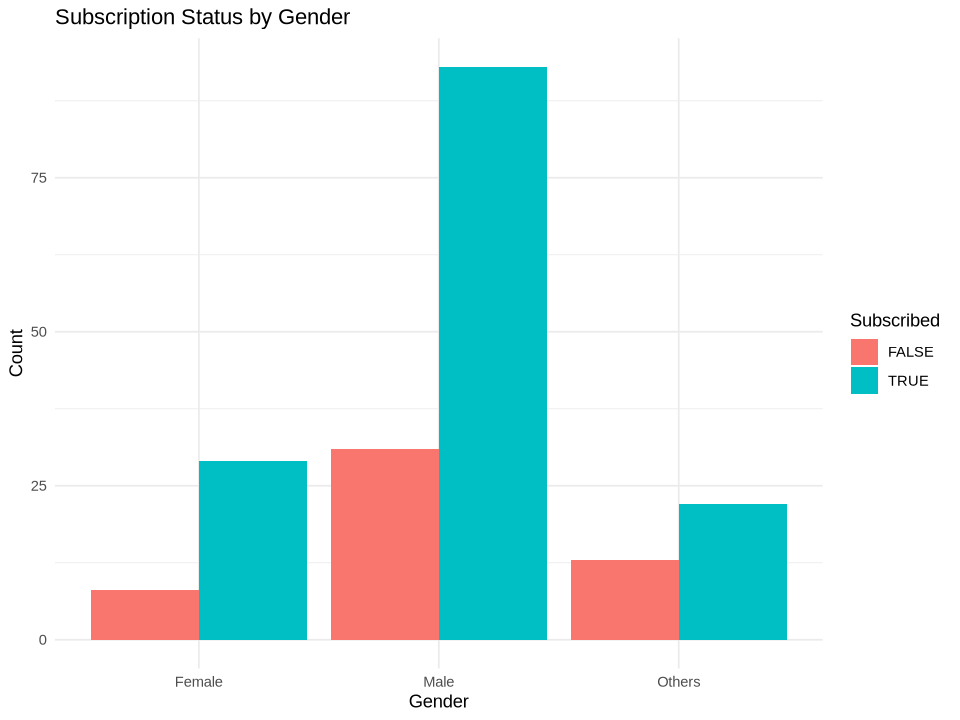

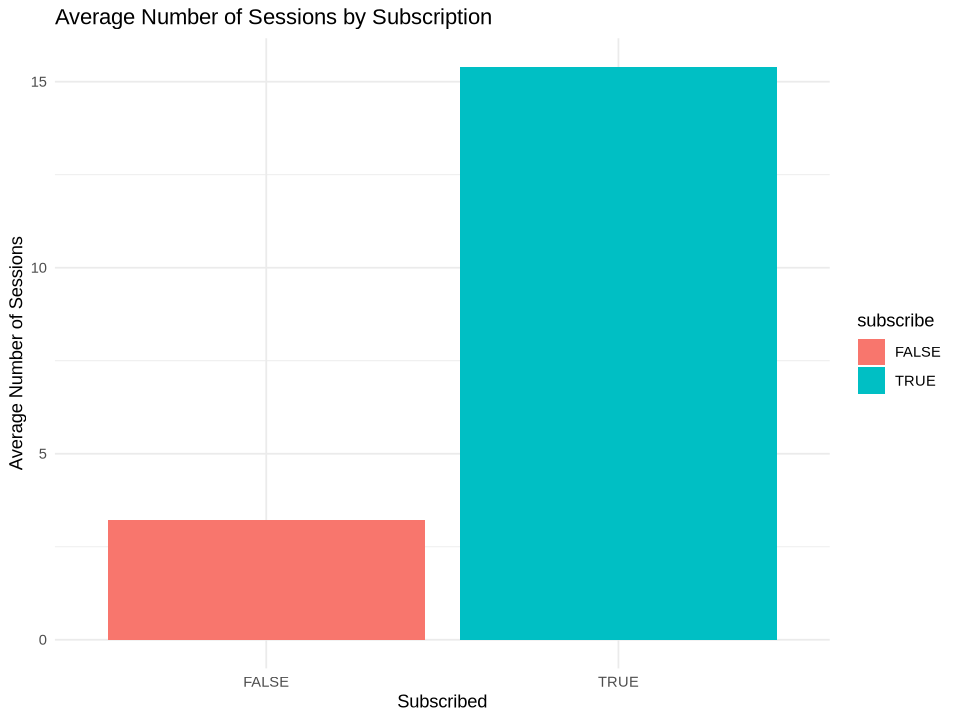

In [50]:
options(repr.plot.width = 8, repr.plot.height = 6)

library(dplyr)
library(tidyr)
library(ggplot2)



# Step 1: Clean and prepare gender categories (optional if already clean)
clear_data <- players|>
  mutate(gender = case_when(
    gender %in% c("Male", "male") ~ "Male",
    gender %in% c("Female", "female") ~ "Female",
    TRUE ~ "Others"  # Handles "Non-binary", "Other", NA, etc.
  ))

# Step 2: Plot
gender_subscribe <- ggplot(df, aes(x = gender, fill = subscribe)) +
  geom_bar(position = "dodge") +
  labs(
    title = "Subscription Status by Gender",
    x = "Gender",
    y = "Count",
    fill = "Subscribed"
  ) +
  theme_minimal()

num_session_subscribe <- players|>
  group_by(subscribe) %>%
  summarise(mean_sessions = mean(num_sessions, na.rm = TRUE)) %>%
  ggplot(aes(x = subscribe, y = mean_sessions, fill = subscribe)) +
  geom_col() +
  labs(
    title = "Average Number of Sessions by Subscription",
    x = "Subscribed",
    y = "Average Number of Sessions"
  ) +
  theme_minimal()
gender_subscribe
num_session_subscribe

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 22 rows.
               ✖ Assigned data has 24 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 24 to size 22.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,.metric,.estimator,mean,n,std_err,.config
<dbl>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
7,accuracy,binary,0.7428846,4,0.007286575,Preprocessor1_Model07


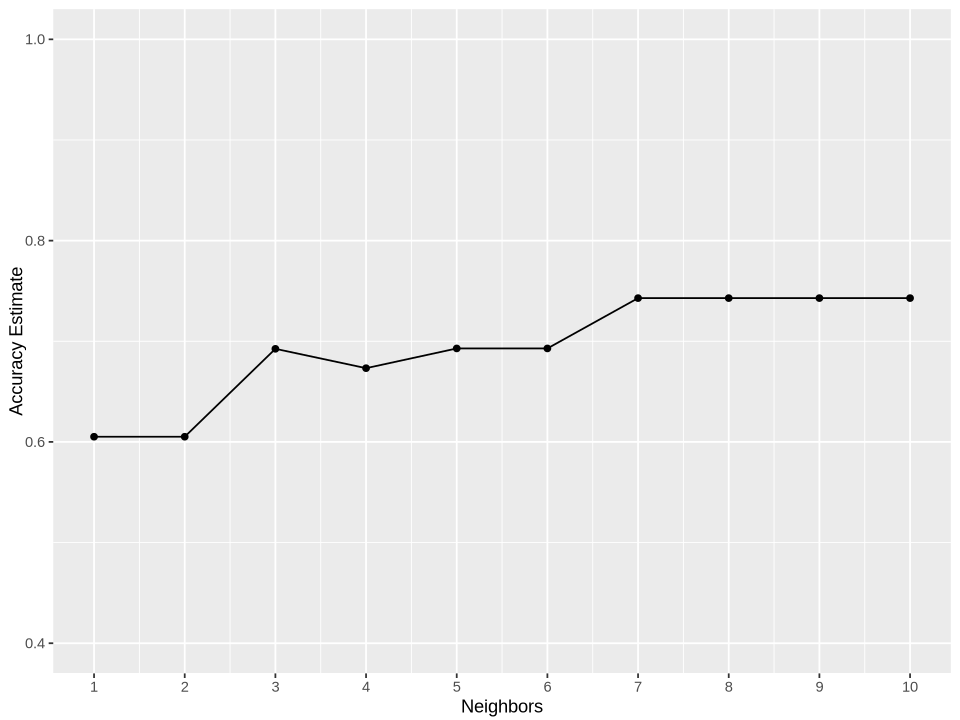

In [54]:

players <- players|>
mutate(subscribe = as.factor(subscribe))


set.seed(1234)
players_split <- initial_split(players, strata = subscribe)
train_split <- training(players_split)
test_split <- testing(players_split)

player_recipe <- recipe(subscribe ~ ., data = train_split)

player_vfold <- vfold_cv(players, v = 5, strata = subscribe)

knn_model <- nearest_neighbor(neighbors = tune(), weight_func = "rectangular") |>
  set_engine("kknn") |>
  set_mode("classification")

p_vals <- tibble(neighbors = seq(from = 1, to = 10, by = 1))

player_result <- workflow() |>
add_recipe(player_recipe)|>
add_model(knn_model)|>
tune_grid(resamples = player_vfold, grid = p_vals) |>
collect_metrics()

accuracies <- player_result |> 
       filter(.metric == "accuracy")

accuracy_versus_k <- ggplot(accuracies, aes(x = neighbors, y = mean))+
       geom_point() +
       geom_line() +
       labs(x = "Neighbors", y = "Accuracy Estimate") +
       scale_x_continuous(breaks = seq(0, 14, by = 1)) +  # adjusting the x-axis
       scale_y_continuous(limits = c(0.4, 1.0)) # adjusting the y-axis


best_k <- accuracies |> 
arrange(desc(mean)) |> 
slice(1)

# neighbors = 7 are the highest

best_k
accuracy_versus_k

In [56]:
final_knn <- nearest_neighbor(neighbor = 7, weight_func = "rectangular")|>
set_engine("kknn")|>
set_mode("classification")

final_workflow <- workflow() |>
  add_recipe(player_recipe) |>
  add_model(final_knn)

final_fit <- final_workflow |>
  fit(data = train_split)

test_predictions <- predict(final_fit, test_split) |>
  bind_cols(test_split)

metrics <- test_predictions |>
  metrics(truth = subscribe, estimate = .pred_class)|>
    filter(.metric	 == "accuracy")|>
    pull(.estimate)

metrics


conf <- test_predictions |>
  conf_mat(truth = subscribe, estimate = .pred_class)
conf

[1] 0.40625

          Truth
Prediction FALSE TRUE
     FALSE     3   14
     TRUE      5   10